# Time Series Analysis Notebook (Real Dataset)

This notebook demonstrates an end-to-end time series workflow on a **real dataset**: **Monthly Sunspot Numbers** (commonly used in time series research and included with `statsmodels`).

It covers:
- Data loading and exploration
- Visualization and seasonality/trend inspection
- Stationarity checks (ADF/KPSS)
- ACF/PACF diagnostics
- Baseline forecasting
- ARIMA model selection and fitting
- Forecasting and accuracy evaluation


In [2]:
# If you're running this on a fresh environment, install dependencies:
# !pip -q install statsmodels pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.datasets import sunspots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.figsize'] = (12, 4)


## 1) Load the data

The `sunspots` dataset contains historical monthly sunspot activity. We'll convert it into a proper `pandas.Series` with a datetime index.


In [14]:
data = sunspots.load_pandas().data
data.head(), data.tail(), data.shape

(     YEAR  SUNACTIVITY
 0  1700.0          5.0
 1  1701.0         11.0
 2  1702.0         16.0
 3  1703.0         23.0
 4  1704.0         36.0,
        YEAR  SUNACTIVITY
 304  2004.0         40.4
 305  2005.0         29.8
 306  2006.0         15.2
 307  2007.0          7.5
 308  2008.0          2.9,
 (309, 2))

<div style="text-align: center;">
    <img src="https://raw.githubusercontent.com/msfasha/307304-Data-Mining/main/images/sunspots.jpg" alt="Statmodels Sunspots Dataset" width="600"/>
</div>

In [4]:
# The dataset includes columns: 'YEAR' and 'SUNACTIVITY'
# Convert YEAR (float) into monthly dates.
# Many versions store fractional year (e.g., 1700.0833...), which encodes month.
# We'll reconstruct a monthly DateTimeIndex robustly.

year_float = data['YEAR'].to_numpy()
sun = data['SUNACTIVITY'].to_numpy()

# Convert fractional years to month index (1..12)
years = np.floor(year_float).astype(int)
frac = year_float - years
months = np.clip(np.round(frac * 12 + 1).astype(int), 1, 12)

dates = pd.to_datetime(
    {'year': years, 'month': months, 'day': 1}
)

ts = pd.Series(sun, index=dates).sort_index()
ts.name = "Monthly Sunspot Activity"

ts.head(), ts.index.min(), ts.index.max(), ts.isna().sum()

(1700-01-01     5.0
 1701-01-01    11.0
 1702-01-01    16.0
 1703-01-01    23.0
 1704-01-01    36.0
 Name: Monthly Sunspot Activity, dtype: float64,
 Timestamp('1700-01-01 00:00:00'),
 Timestamp('2008-01-01 00:00:00'),
 0)

## 2) Quick exploration

In [5]:
ts.describe()

count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: Monthly Sunspot Activity, dtype: float64

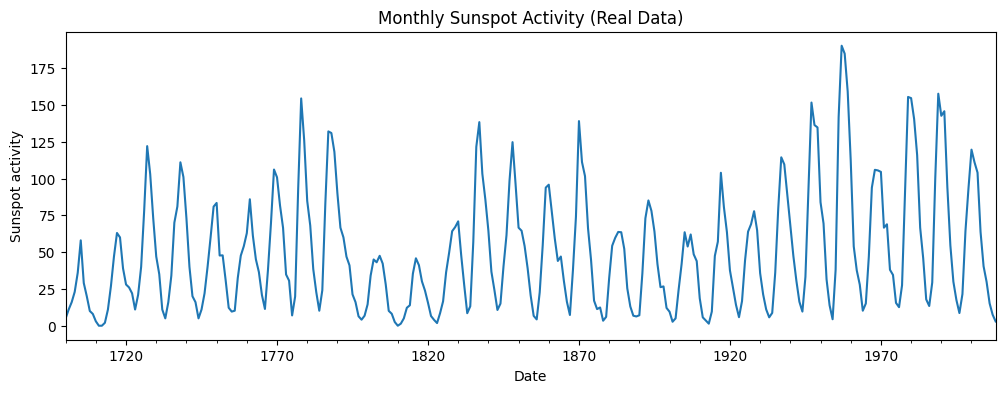

In [6]:
ts.plot()
plt.title("Monthly Sunspot Activity (Real Data)")
plt.xlabel("Date")
plt.ylabel("Sunspot activity")
plt.show()

## 3) Train/Test split

We'll hold out the last few years as a test set.


In [7]:
# Hold out the last 5 years (60 months)
test_horizon = 60

train = ts.iloc[:-test_horizon]
test = ts.iloc[-test_horizon:]

train.index.min(), train.index.max(), test.index.min(), test.index.max(), len(train), len(test)

(Timestamp('1700-01-01 00:00:00'),
 Timestamp('1948-01-01 00:00:00'),
 Timestamp('1949-01-01 00:00:00'),
 Timestamp('2008-01-01 00:00:00'),
 249,
 60)

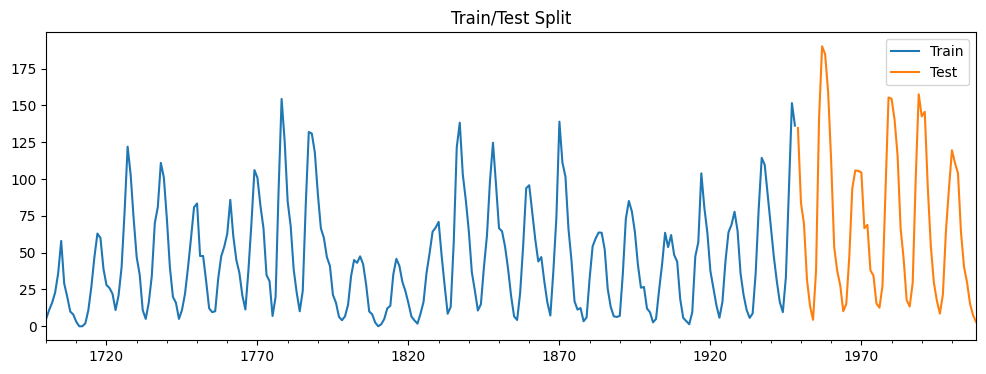

In [8]:
train.plot(label="Train")
test.plot(label="Test")
plt.title("Train/Test Split")
plt.legend()
plt.show()

## 4) Decomposition with STL

STL (Seasonal-Trend decomposition using Loess) is useful for exploring trend and repeating structure.

Sunspots exhibit **cyclical behavior** (roughly ~11 years), which is not strictly a fixed seasonal pattern like monthly retail seasonality, but STL can still provide insight.


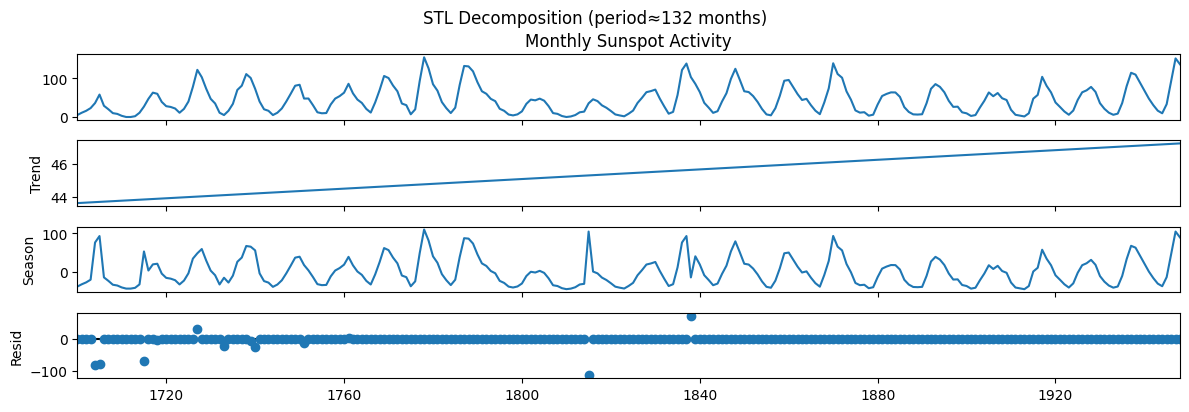

In [9]:
# Choose a period. For sunspots, an ~11-year cycle ≈ 132 months.
stl = STL(train, period=132, robust=True)
res = stl.fit()

res.plot()
plt.suptitle("STL Decomposition (period≈132 months)", y=1.02)
plt.show()

## 5) Stationarity checks (ADF and KPSS)

- **ADF** tests the null hypothesis that a unit root exists (non-stationary). Low p-value → reject null → more stationary.
- **KPSS** tests the null hypothesis that the series is stationary. Low p-value → reject null → non-stationary.


In [10]:
def adf_test(series):
    out = adfuller(series.dropna(), autolag="AIC")
    return {
        "ADF statistic": out[0],
        "p-value": out[1],
        "n_lags": out[2],
        "n_obs": out[3]
    }

def kpss_test(series, regression="c"):
    stat, pval, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")
    return {
        "KPSS statistic": stat,
        "p-value": pval,
        "n_lags": lags
    }

adf_test(train), kpss_test(train)

C:\Users\me\AppData\Local\Temp\ipykernel_14576\4149292106.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(series.dropna(), regression=regression, nlags="auto")


({'ADF statistic': -2.9748603692623097,
  'p-value': 0.037309759442603924,
  'n_lags': 8,
  'n_obs': 240},
 {'KPSS statistic': 0.10762408792487697, 'p-value': 0.1, 'n_lags': 6})

## 6) ACF / PACF diagnostics

These plots help inform AR/MA order choices:
- ACF: autocorrelation at different lags
- PACF: partial autocorrelation after removing intermediate effects


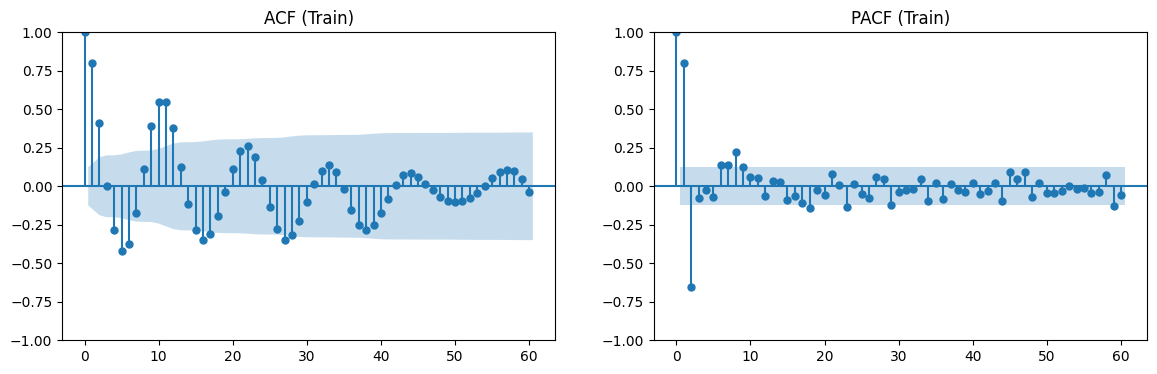

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train, lags=60, ax=ax[0])
plot_pacf(train, lags=60, ax=ax[1], method="ywm")
ax[0].set_title("ACF (Train)")
ax[1].set_title("PACF (Train)")
plt.show()

## 7) Baseline forecast

A simple baseline helps contextualize more complex models.
We'll use:
- **Naive** forecast: last observed value
- **Seasonal naive (cycle)**: last value from 132 months ago (approx sunspot cycle)


In [12]:
def naive_forecast(train, steps):
    return pd.Series([train.iloc[-1]] * steps, index=test.index)

def seasonal_naive_forecast(train, steps, season_len):
    # For each step, use the value from season_len months earlier
    idx = np.arange(len(train), len(train) + steps)
    vals = [train.iloc[i - season_len] if (i - season_len) >= 0 else train.iloc[-1] for i in idx]
    return pd.Series(vals, index=test.index)

naive_pred = naive_forecast(train, len(test))
snaive_pred = seasonal_naive_forecast(train, len(test), season_len=132)

def eval_forecast(y_true, y_pred, label="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return pd.Series({"MAE": mae, "RMSE": rmse}, name=label)

pd.concat([
    eval_forecast(test, naive_pred, "Naive"),
    eval_forecast(test, snaive_pred, "Seasonal Naive (132)")
], axis=1)

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
plt.figure(figsize=(12,4))
train.iloc[-300:].plot(label="Train (last 300)")
test.plot(label="Test")
naive_pred.plot(label="Naive")
snaive_pred.plot(label="Seasonal Naive (132)")
plt.title("Baseline Forecasts")
plt.legend()
plt.show()

## 8) ARIMA model selection (lightweight grid search)

We'll do a small ARIMA(p,d,q) search using AIC on the training data.  
For many real projects you'd expand this, add seasonal terms (SARIMA), and/or use time series cross-validation.

Note: Sunspots have strong cyclicality; a pure ARIMA may not perfectly capture multi-year cycles, but it's useful for demonstration.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

def arima_grid_search(series, p_range=range(0, 6), d_range=range(0, 3), q_range=range(0, 6)):
    best = {"aic": np.inf, "order": None, "model": None}
    for p in p_range:
        for d in d_range:
            for q in q_range:
                if p == 0 and d == 0 and q == 0:
                    continue
                try:
                    model = ARIMA(series, order=(p,d,q)).fit()
                    if model.aic < best["aic"]:
                        best = {"aic": model.aic, "order": (p,d,q), "model": model}
                except Exception:
                    continue
    return best

best = arima_grid_search(train, p_range=range(0,6), d_range=range(0,3), q_range=range(0,6))
best["order"], best["aic"]

## 9) Fit best ARIMA and forecast

In [ ]:
best_order = best["order"]
arima_fit = ARIMA(train, order=best_order).fit()
arima_fit.summary()

In [ ]:
forecast_res = arima_fit.get_forecast(steps=len(test))
pred = forecast_res.predicted_mean
ci = forecast_res.conf_int()

metrics = eval_forecast(test, pred, f"ARIMA{best_order}")
metrics

In [ ]:
plt.figure(figsize=(12,4))
train.iloc[-300:].plot(label="Train (last 300)")
test.plot(label="Test")
pred.plot(label=f"ARIMA{best_order} Forecast")

plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.title("ARIMA Forecast with Confidence Interval")
plt.legend()
plt.show()

## 10) Residual diagnostics

A good model's residuals should look roughly like white noise:
- No obvious autocorrelation left
- Mean near zero
- Roughly stable variance


In [ ]:
resid = arima_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(14,4))
resid.plot(ax=ax[0])
ax[0].set_title("Residuals over time")
plot_acf(resid.dropna(), lags=60, ax=ax[1])
ax[1].set_title("ACF of residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid.dropna(), bins=40)
plt.title("Residual histogram")
plt.show()

## 11) Comparison summary

In [ ]:
summary = pd.concat([
    eval_forecast(test, naive_pred, "Naive"),
    eval_forecast(test, snaive_pred, "Seasonal Naive (132)"),
    eval_forecast(test, pred, f"ARIMA{best_order}")
], axis=1).T.sort_values("RMSE")

summary

## 12) Next steps (if you want to extend)

- Try **SARIMA** with an explicit seasonal period (e.g., 132) and compare.
- Use **time series cross-validation** (rolling/expanding windows).
- Consider **state space models** (e.g., UnobservedComponents) for cyclical dynamics.
- If you have your own dataset: replace the loading cell, ensure a datetime index, and rerun the pipeline.
